# Perform SVD on CFD data

Decompress data and load the snapshots

In [1]:
import numpy as np
import os
from IPython.display import clear_output

folder_to_save = '../../Data/CFDBenchFlowCyl'

id_cases = [f for f in os.listdir(folder_to_save+'/') if os.path.isdir(os.path.join(folder_to_save+'/', f))]
id_cases.sort()

snap_data = list()
for case_i in range(1, len(id_cases)):
    snap_data.append(dict())

    snap_data[case_i-1]['u'] = np.load(folder_to_save + '/' + id_cases[case_i] + '/u.npy')
    snap_data[case_i-1]['v'] = np.load(folder_to_save + '/' + id_cases[case_i] + '/v.npy')

print(len(snap_data))
print(snap_data[0]['u'].shape)
print(snap_data[0]['v'].shape)

Nt, Nhx, Nhy = snap_data[0]['u'].shape
Ns = len(snap_data)

10
(1000, 64, 64)
(1000, 64, 64)


Create Plotter objects for visualization

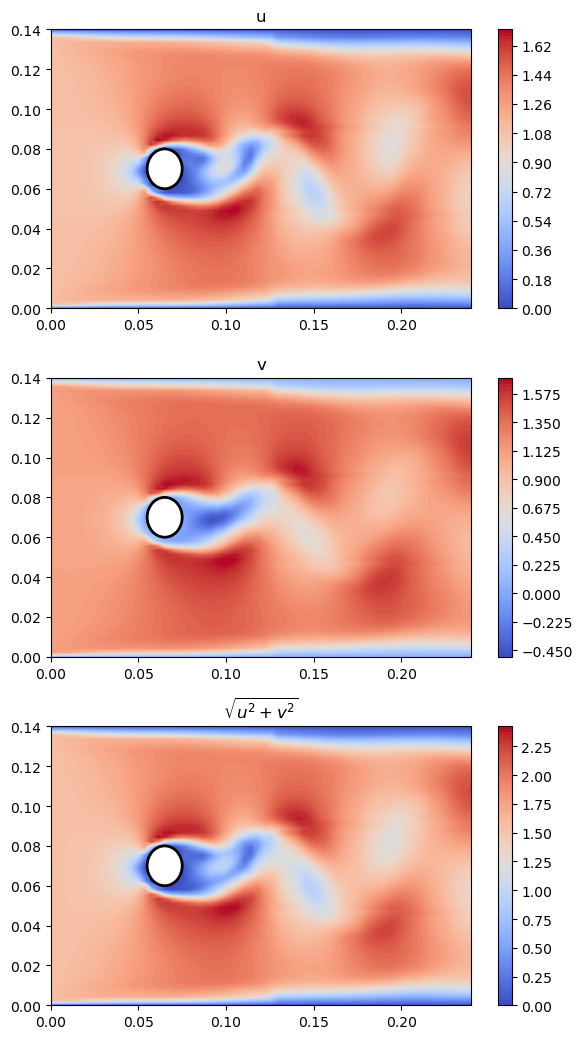

In [2]:
from matplotlib import patches, cm
import matplotlib.pyplot as plt

def create_circle(ax):
    radius = 0.01
    center = ((0.06+radius/2), (0.06+radius))
    circle = patches.Ellipse(center, 2*radius, 2*radius, edgecolor='black', facecolor='white', linewidth=2)
    ax.add_patch(circle)

radius = 0.01
length = 0.16 + 0.06 + 2*radius
height = 2 * 0.06 + 2*radius

grid = np.meshgrid(np.linspace(0, length, Nhx), np.linspace(0, height, Nhy))

fig, axs = plt.subplots(3,1,figsize=(6, 6 * 3 * height / length))

ux_cont = axs[0].contourf(grid[0], grid[1], snap_data[-1]['u'][-1], cmap=cm.coolwarm, levels=100)
fig.colorbar(ux_cont, ax=axs[0])
axs[0].set_title('u')

uy_cont = axs[1].contourf(grid[0], grid[1], snap_data[-1]['v'][-1], cmap=cm.coolwarm, levels=100)
fig.colorbar(uy_cont, ax=axs[1])
axs[1].set_title('v')

umag_cont = axs[2].contourf(grid[0], grid[1], np.sqrt(snap_data[-1]['u'][-1]**2 + snap_data[-1]['v'][-1]**2), cmap=cm.coolwarm, levels=100)
fig.colorbar(umag_cont, ax=axs[2])
axs[2].set_title(r'$\sqrt{u^2+v^2}$')

for ax in axs:
    create_circle(ax)

plt.tight_layout()
plt.show()

Let us save the space and time dimensions

In [3]:
Nt_list  = [snap_data[uu]['u'].shape[0] for uu in range(Ns)]
Nhx_list = [snap_data[uu]['u'].shape[1] for uu in range(Ns)]
Nhy_list = [snap_data[uu]['u'].shape[2] for uu in range(Ns)]

Create function for plotting

In [4]:
import matplotlib.patches as patches

def get_mag(uvec, Nx, Ny):
    return np.sqrt(uvec[:Nx*Ny]**2 + uvec[Nx*Ny:]**2)

def create_circle(ax):
    radius = 0.01
    center = ((0.06+radius/2), (0.06+radius))
    # center_scaled = ((0.06+radius) * 64 / (0.16 + 0.06 + 2*radius), (0.06+radius) * 64 / (2 * 0.06 + 2*radius))
    # radius_x_scaled = radius * 64 / (0.16 + 0.06 + 2*radius)
    # radius_y_scaled = radius * 64 / (2 * 0.06 + 2*radius)

    # circle = patches.Ellipse(center_scaled, radius_x_scaled, radius_y_scaled, edgecolor='black', facecolor='white', linewidth=2)
    circle = patches.Ellipse(center, 2*radius, 2*radius, edgecolor='black', facecolor='white', linewidth=2)
    ax.add_patch(circle)

Visualisation of the snapshots

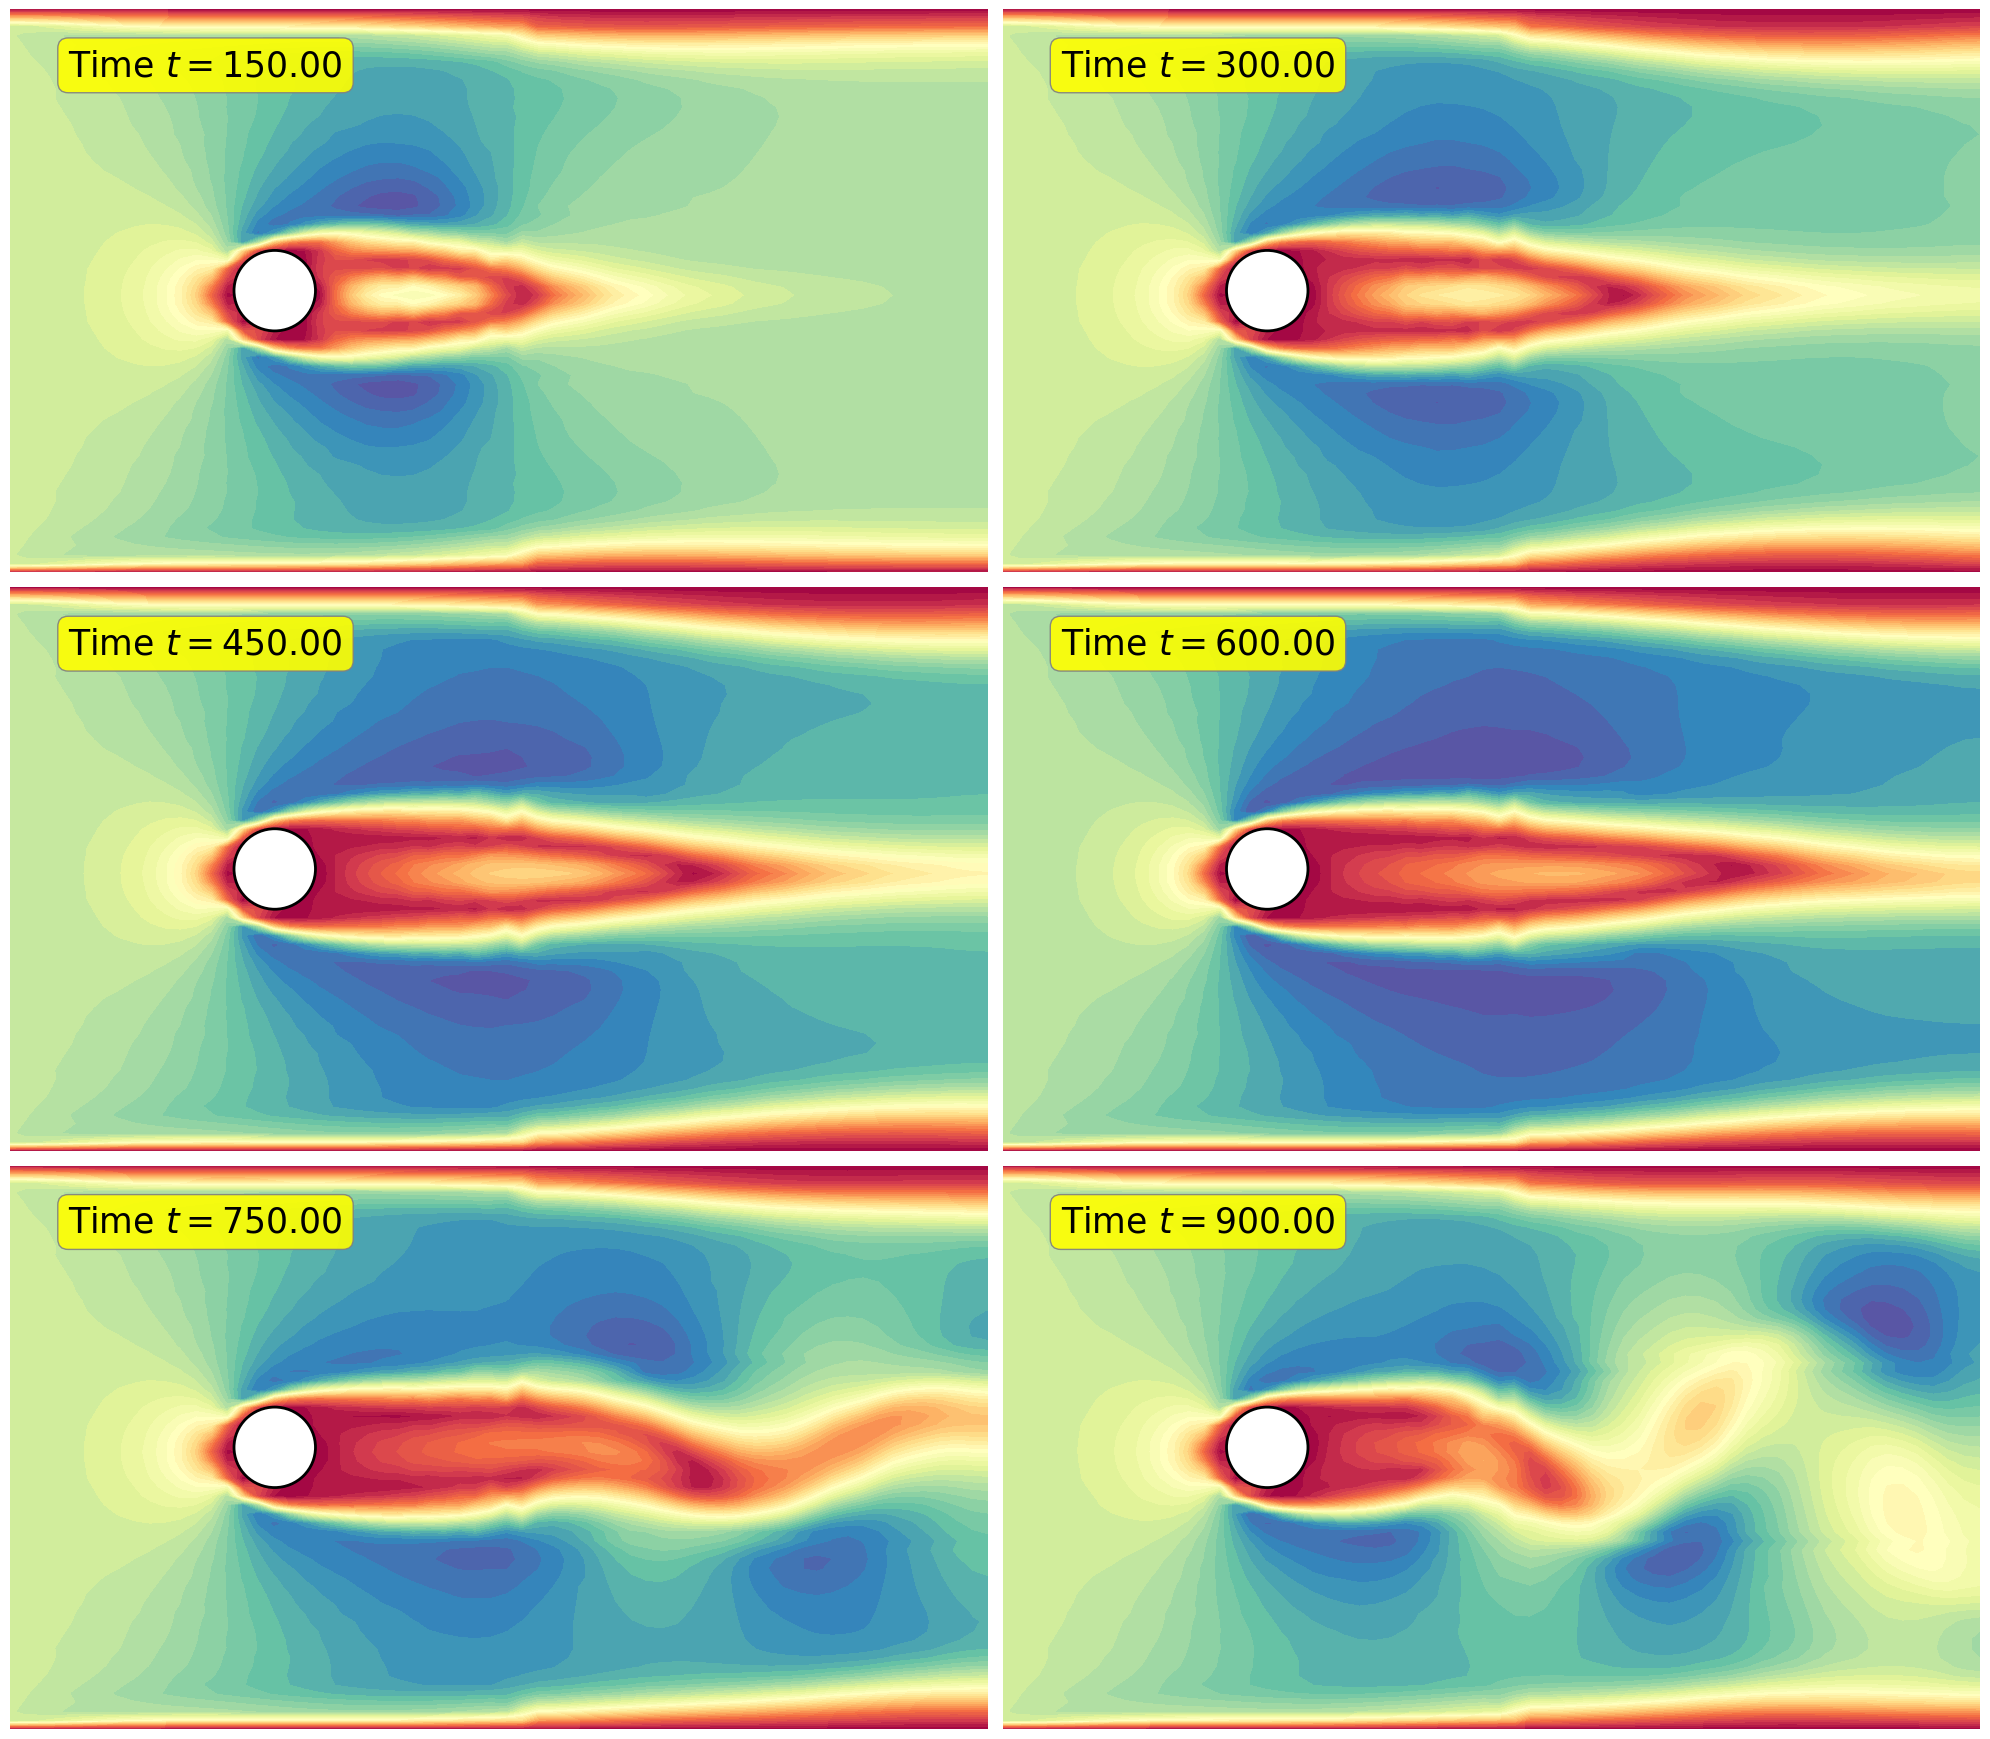

In [5]:
# os.makedirs('images', exist_ok=True)

radius = 0.01
length = 0.16 + 0.06 + 2*radius
height = 2 * 0.06 + 2*radius

grid = np.meshgrid(np.linspace(0, length, Nhx), np.linspace(0, height, Nhy))

cmap = cm.Spectral

mu_to_plot = np.sort(np.random.choice(Ns, 1, replace=False))[0]

nrows = 3
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(10 * ncols, nrows * 10 * height / length))
axs = axs.flatten()

time_to_plot = np.arange(150, Nt, 150)

for kk in range(nrows*ncols):
    tt = time_to_plot[kk]
    cont = axs[kk].contourf(grid[0], grid[1], np.sqrt(
        snap_data[mu_to_plot]['u'][tt, :, :]**2 + snap_data[mu_to_plot]['v'][tt, :, :]**2
    ), levels=40, cmap=cmap)
    create_circle(axs[kk])

    axs[kk].axis('off')

    axs[kk].annotate(r'Time $t={:.2f}$'.format(tt), xy=(0.2, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=25,
                     bbox=dict(boxstyle="round", fc="yellow", ec="0.5", alpha=0.9))
plt.tight_layout()
# fig.savefig('FlowCylExample.png', dpi=200, bbox_inches='tight')


Reshape data into matrix format $N_s\times N_t\times \mathcal{N}_h$

In [7]:
from time import process_time, time

comput_time = dict()

Np = len(snap_data)

snap_data_matrix = np.zeros((Np, Nt, Nhx*Nhy*2))

for pp in range(Np):
    for tt in range(Nt):
        snap_data_matrix[pp, tt, :] = np.concatenate((snap_data[pp]['u'][tt, :, :].flatten(), snap_data[pp]['v'][tt, :, :].flatten()), axis=0)


## Randomized SVD

In [8]:
from sklearn.utils.extmath import randomized_svd

_time = np.array([process_time(), time()])
rsvd = randomized_svd(snap_data_matrix.reshape((-1, snap_data_matrix.shape[2])).T, n_components=100, n_iter='auto')
comput_time['rSVD'] = np.array([process_time(), time()]) - _time

Plotting Modes

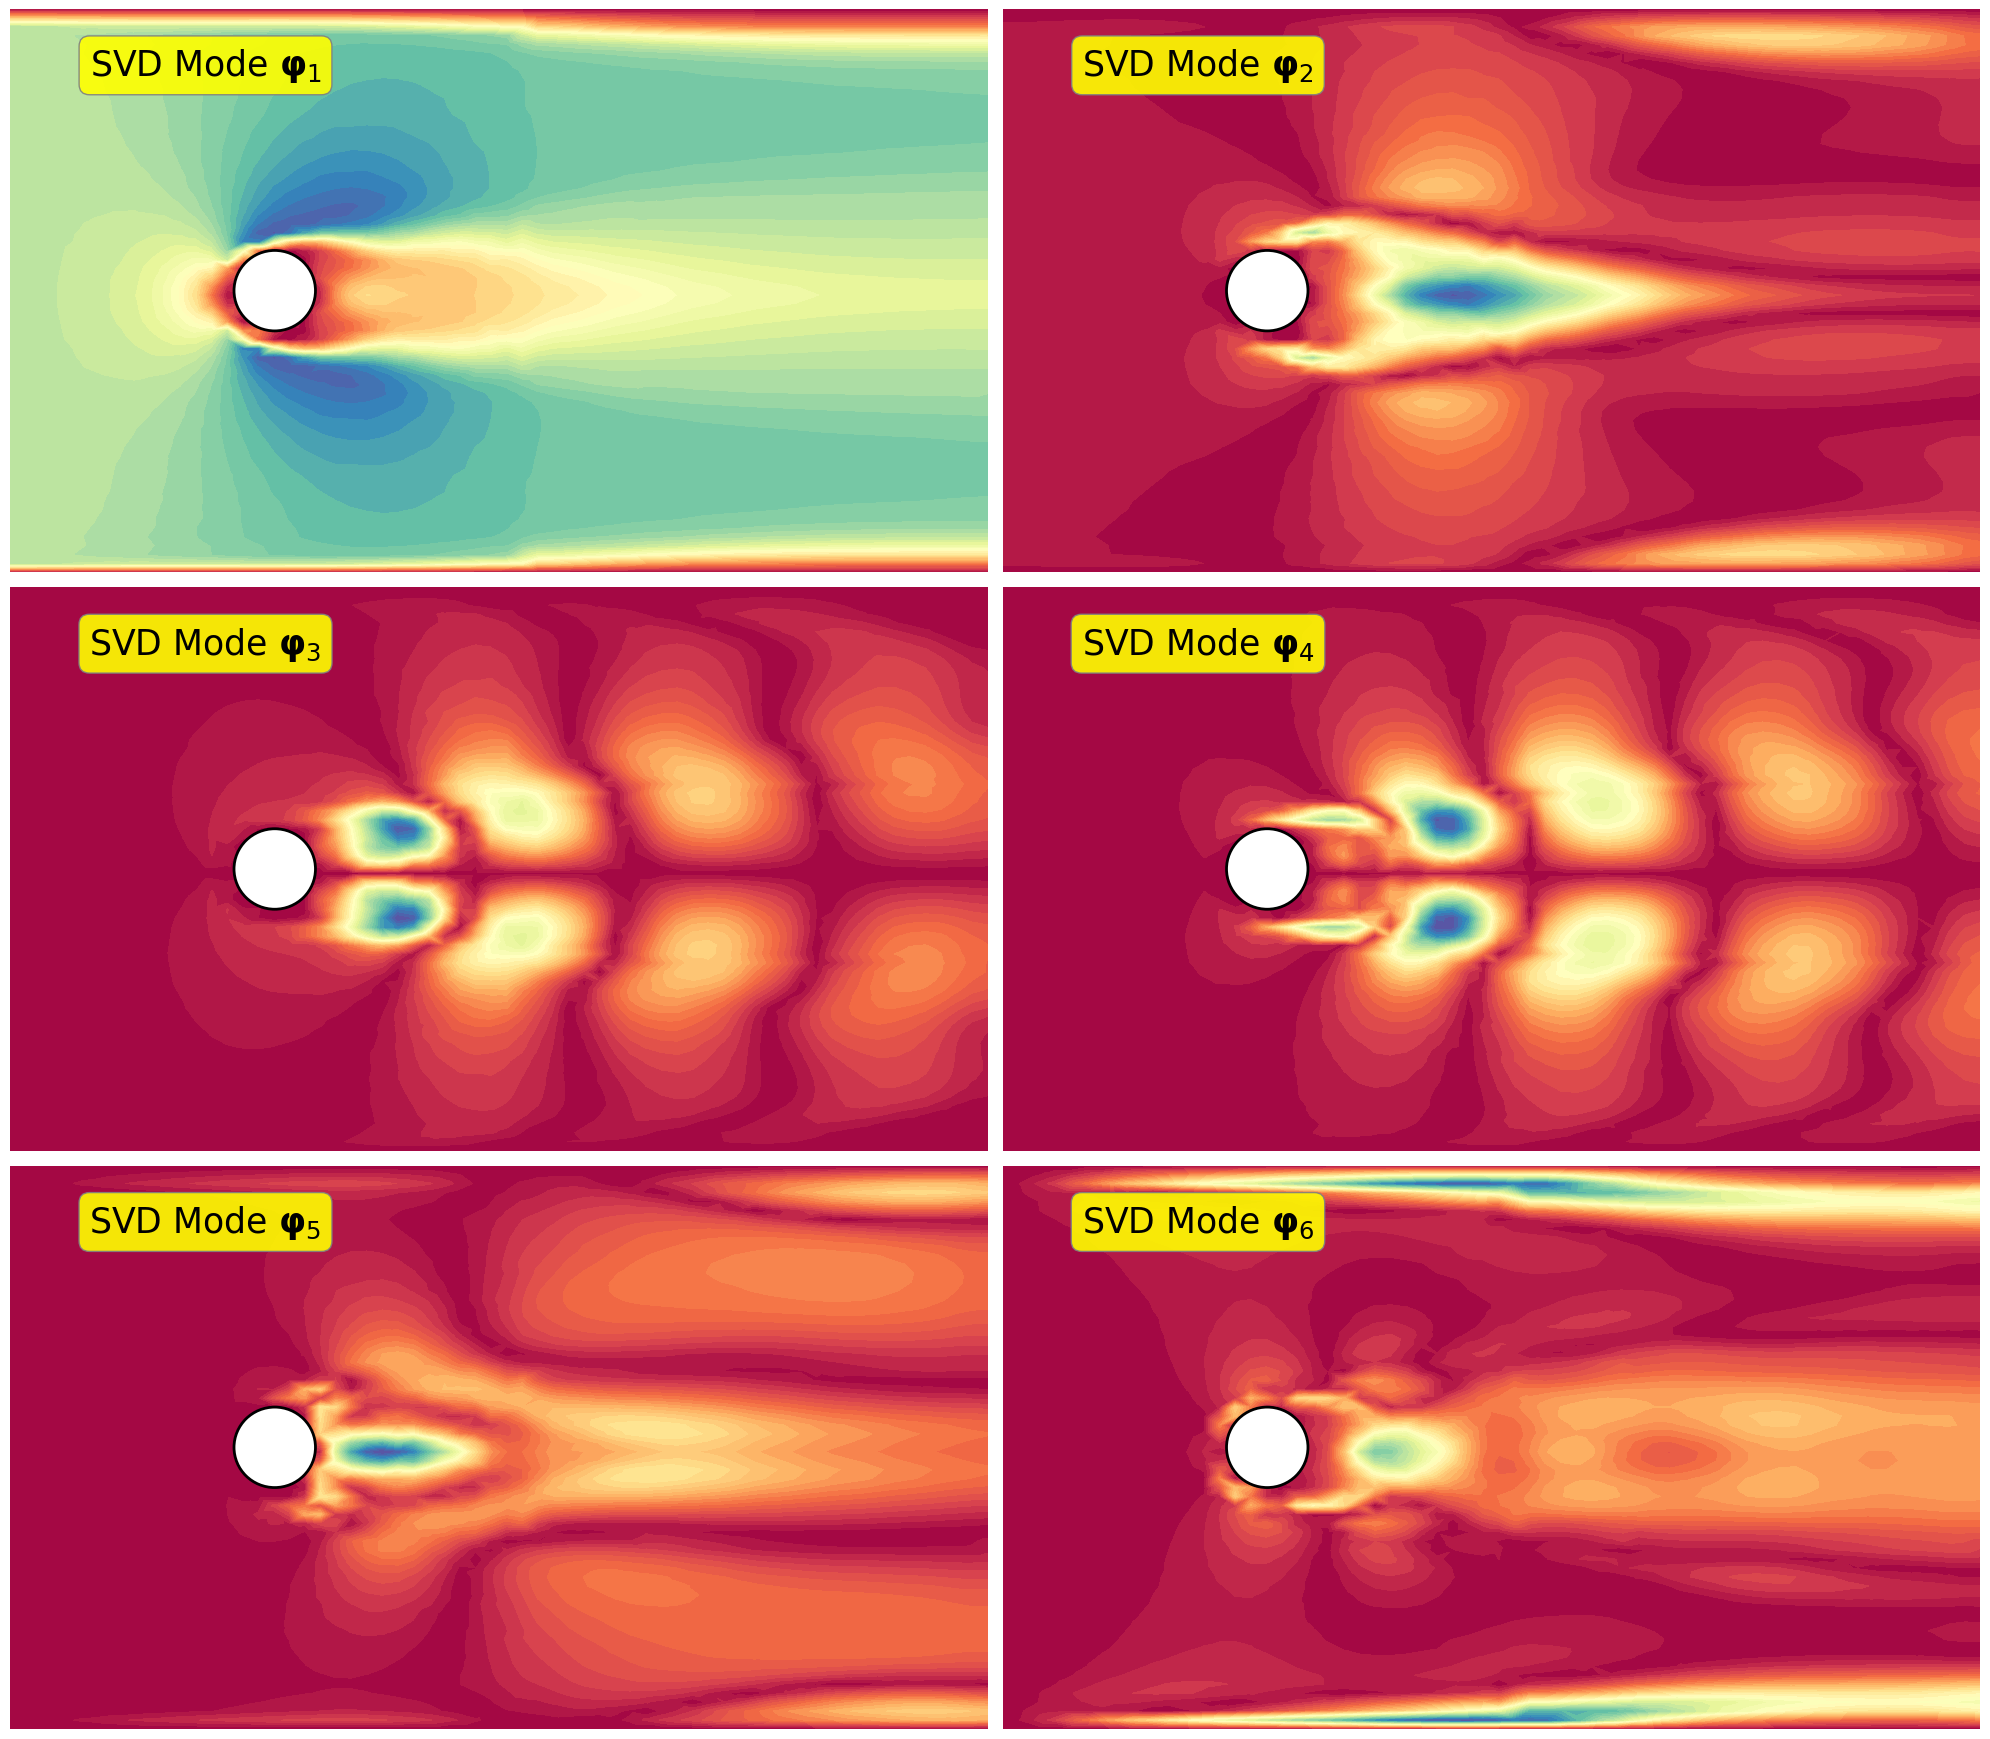

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(10*2, 3 * 10 * height / length))

axs = axs.flatten()
for ii in range(len(axs)):
    axs[ii].tricontourf(grid[0].flatten(), grid[1].flatten(), get_mag(rsvd[0][:, ii], Nhx, Nhy), cmap=cmap, levels=40)
    create_circle(axs[ii])
    axs[ii].axis('off')
    axs[ii].annotate(r'SVD Mode $\boldsymbol{\varphi}_' + str(ii+1)+'$', xy=(0.2, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=25,
                     bbox=dict(boxstyle="round", fc="yellow", ec="0.5", alpha=0.9))

plt.tight_layout()
# fig.savefig('cylinder_bc_modes.png', dpi=200, bbox_inches='tight')


Plotting reduced coefficients

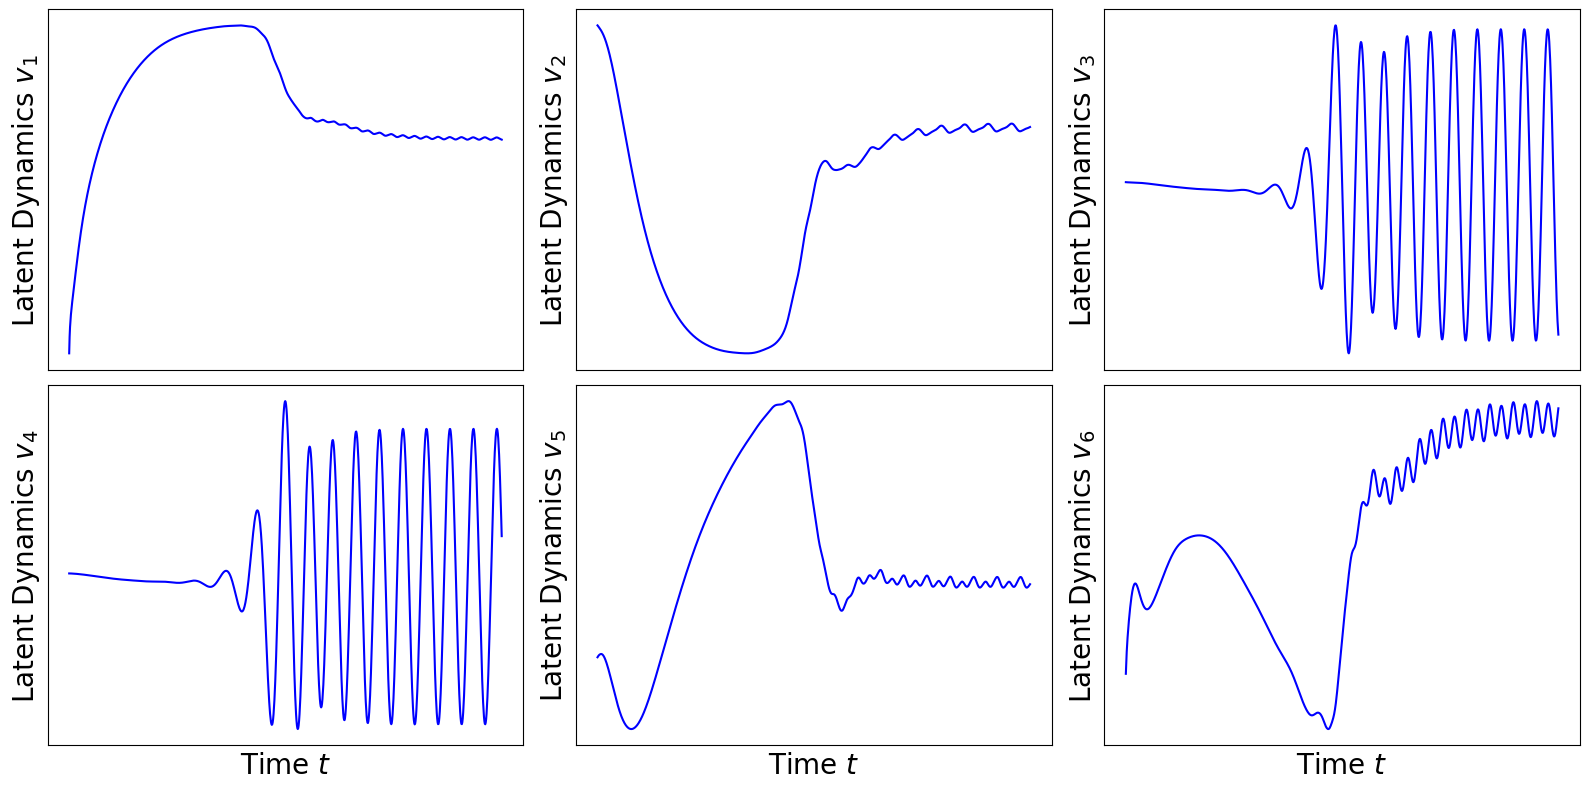

In [10]:
fig, axs = plt.subplots(2,3, sharex=True, figsize=(8*2, 4 * 2))
axs = axs.flatten()

muss = np.random.choice(Ns, size=1, replace=False)

for jj, mu in enumerate(muss):
    idx_to_plot = np.arange(Nt * mu, Nt * (mu+1))

    for ii in range(len(axs)):
        axs[ii].plot(rsvd[2][ii, idx_to_plot], 'b')
        axs[ii].set_xticks([])
        axs[ii].set_yticks([])
        axs[ii].set_ylabel(r'Latent Dynamics $v_'+str(ii+1)+'$', fontsize=20)

axs = axs.reshape(2,3)
[axs[-1, ii].set_xlabel('Time $t$', fontsize=20) for ii in range(3)]

plt.tight_layout()

# fig.savefig('cylinder_bc_latent_dyn.pdf', dpi=200, bbox_inches='tight')